In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from scipy.optimize import minimize
import scipy.optimize as opt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [5]:
def compute_slope(x1, y1, x2, y2):
    if x2 != x1:
        return (y2 - y1) / (x2 - x1)
    else:
        return None

In [616]:
n = 1.375          # refractive index
c = 3.00e10        # speed of light in vacuum, cm/s
c = c / n          # speed of light in medium
ua = 0.1 *10   # cm
us = 9.0 *10  # cm
g = 0.85 # anisotropy factor unitless
us_prime = us*(1-g)
D = 1/(3*(ua+us_prime)) # cm
p = 1.5 # x2+y2 cm
# z_o:
z_o = 1/(us*(1-g))
t = np.linspace(0, 1e-08, 1000)

In [103]:
us_prime

13.500000000000002

In [9]:

def R_rho_t(t, ua, c, D, z0, rho=1.5):
    # Avoid division by zero for t = 0
    t = np.where(t == 0, np.finfo(float).eps, t)  # Replace 0 with a small number

    # Prefactor: (4 * pi * D * c) ** (-3/2)
    A = (4 * np.pi * D * c) ** (-1.5)

    # z0 * t ** (-5/2)
    T = z0 * (t ** (-2.5))

    # Exponential terms
    exp1 = np.exp(-ua * c * t)
    exp2 = np.exp(-(rho**2 + z0**2) / (4 * D * c * t))

    # Return the product
    return A * T * exp1 * exp2

In [10]:
intensity = [R_rho_t(x, ua, c, D, z_o, rho=1.5) for x in t]

### Intensity

In [82]:
ln_intensity = -ua * c * t \
               - (3/2) * np.log(4 * np.pi * D * c) \
               - (5/2) * np.log(z_o * t) \
               - ((p**2 + z_o**2) / (4 * D * c * t))

def get_ln_intensity(t):
    ln_intensity = -ua * c * t \
               - (3/2) * np.log(4 * np.pi * D * c) \
               - (5/2) * np.log(z_o * t) \
               - ((p**2 + z_o**2) / (4 * D * c * t))
    return ln_intensity
    
# model to fit: 
def ln_intensity_model(t=t, ua=ua, us_prime=us_prime, c=c, p=p):
    D = 1 / (3 * (ua + us_prime))
    z_o = 1 / us_prime
    term1 = -ua * c * t
    term2 = -(3/2) * np.log(4 * np.pi * D * c)
    term3 = -(5/2) * np.log(z_o * t)
    term4 = -((p**2 + z_o**2) / (4 * D * c * t))
    return term1 + term2 + term3 + term4

C:\Users\Haiya\AppData\Local\Temp\ipykernel_21180\2260671063.py:3: RuntimeWarning: divide by zero encountered in log
  - (5/2) * np.log(z_o * t) \
C:\Users\Haiya\AppData\Local\Temp\ipykernel_21180\2260671063.py:4: RuntimeWarning: divide by zero encountered in divide
  - ((p**2 + z_o**2) / (4 * D * c * t))
C:\Users\Haiya\AppData\Local\Temp\ipykernel_21180\2260671063.py:1: RuntimeWarning: invalid value encountered in subtract
  ln_intensity = -ua * c * t \


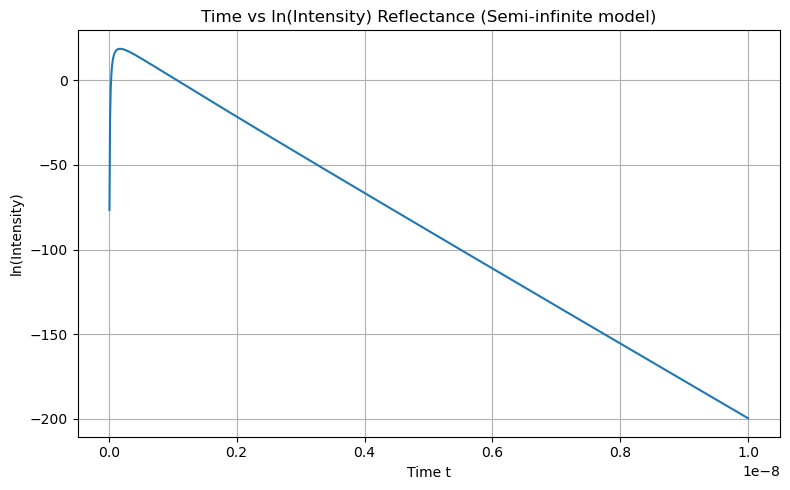

In [85]:
# Time range (in seconds)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(t , ln_intensity)
plt.xlabel("Time t")
plt.ylabel("ln(Intensity)")
plt.title("Time vs ln(Intensity) Reflectance (Semi-infinite model)")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Haiya\AppData\Local\Temp\ipykernel_21180\2260671063.py:19: RuntimeWarning: divide by zero encountered in log
  term3 = -(5/2) * np.log(z_o * t)
C:\Users\Haiya\AppData\Local\Temp\ipykernel_21180\2260671063.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  term4 = -((p**2 + z_o**2) / (4 * D * c * t))
C:\Users\Haiya\AppData\Local\Temp\ipykernel_21180\2260671063.py:21: RuntimeWarning: invalid value encountered in scalar add
  return term1 + term2 + term3 + term4


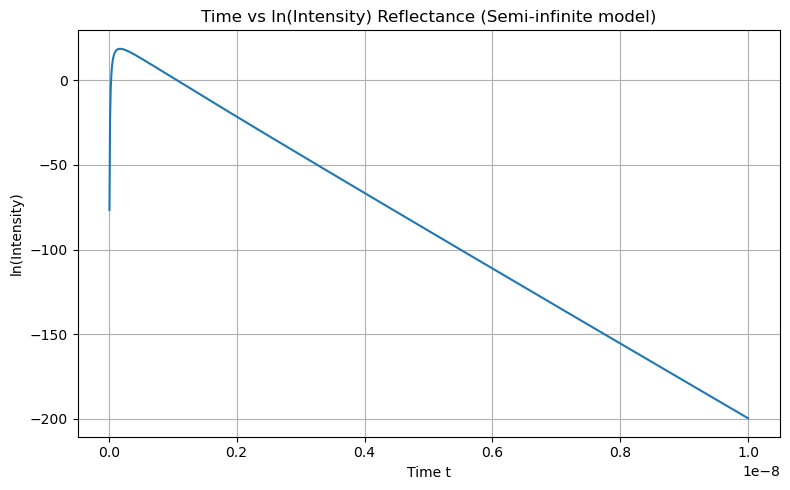

In [93]:
# Time range (in seconds)
# Plot
ln_intensity_model_r = [ln_intensity_model(x, ua=ua, us_prime=us_prime, c=c, p=p) for x in t]
plt.figure(figsize=(8, 5))
plt.plot(t , ln_intensity_model_r)
plt.xlabel("Time t")
plt.ylabel("ln(Intensity)")
plt.title("Time vs ln(Intensity) Reflectance (Semi-infinite model)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
x1 = 2e-9
x2 = 1
ua = -(compute_slope(x1, get_ln_intensity(x1) , x2, get_ln_intensity(x2)))/c
print(ua)

1.000000006808063


### Intensity normalization

In [25]:
intensity[0] = 0

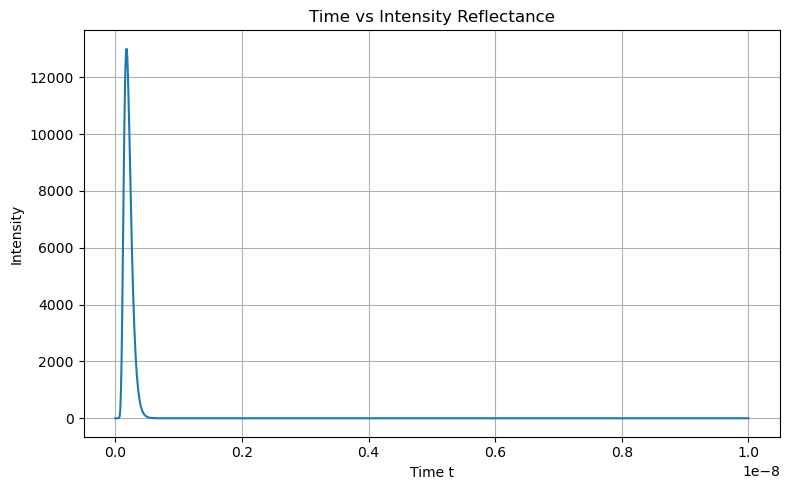

In [27]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(t , intensity)
plt.xlabel("Time t")
plt.ylabel("Intensity")
plt.title("Time vs Intensity Reflectance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
intensity /= np.trapz(intensity, t)

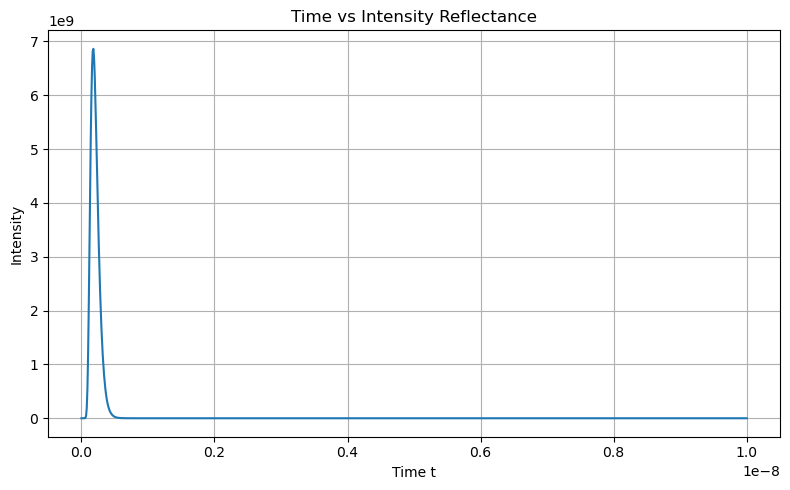

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(t, intensity)
plt.xlabel("Time t")
plt.ylabel("Intensity")
plt.title("Time vs Intensity Reflectance")
plt.grid(True)
plt.tight_layout()
plt.show()

### Transform into FD

In [37]:
from FD_msNIRS import extract_freq  as ef # (target_freq, TPSF, tend, devf):
target_freq = 110e6
tend  = 1e-8

In [38]:
amplitude, udc, phase, x = ef(target_freq, intensity, tend, devf=1000)

In [40]:
print(amplitude, udc, phase, x)

0.9989757683680447 1.0 -0.14248597120343648 -0.14250120810401698


### Optimization based on FD model

$$
\Large U_{AC} = \exp\left(-r \cdot \left( \frac{(v \mu_a)^2 + w^2}{(v D)^2} \right)^{\frac{1}{4}} \cdot \cos\left( \frac{1}{2} \cdot \arctan\left( \frac{w}{v \mu_a} \right) \right) \right) \cdot \frac{S \cdot A}{4 \pi v D \cdot \text{r}}
$$

$$
\Large U_{DC} = \exp\left(-r \cdot \sqrt{\frac{\mu_a}{D}} \right) \cdot \frac{S}{4 \pi v D \cdot \text{r}}
$$

$$
\Large \text{Phase} = r \cdot \left( \frac{(v \mu_a)^2 + w^2}{(v D)^2} \right)^{\frac{1}{4}} \cdot \sin\left( \frac{1}{2} \cdot \arctan\left( \frac{w}{v \mu_a} \right) \right)
$$

In [47]:
U_AC_measured = amplitude
Phase_measured = -phase
v = c
rx = 1.5

In [49]:
print(U_AC_measured, Phase_measured, )

0.9989757683680447 0.14248597120343648


In [51]:
def objective_function(params):
    ua, us_prime, Alpha = params
    D = 1 / (3 * (ua + us_prime))

    term1 = ((v * ua)**2 + w**2) / (v * D)**2
    sqrt_term = term1**(1/4)
    atan_term = np.arctan(w / (v * ua))
    U_AC_calc = np.exp(-rx * sqrt_term * np.cos(0.5 * atan_term)) * (Alpha) / (D * rx)
    #print(U_AC_calc)

    Phase_calc = rx * sqrt_term * np.sin(0.5 * atan_term)
    #print(Phase_calc)
    # U_AC_measured: the measured UAC, phase_measured: the measured phase. 
    error = np.sum((U_AC_calc - U_AC_measured)**2) + np.sum((Phase_calc - Phase_measured)**2)
    print(error)
    return error

In [53]:
initial_guess = [1, 11, 681.9049532479904]  # 0.1, 1.35
bounds = [(0, 2),   
              (10, 20),      # HHb bounds (μM)
              (681.9049532479904, 681.9049532479904)
             ]        # b bounds (range)
w = target_freq

In [55]:
result = opt.minimize(objective_function, initial_guess, bounds=bounds, method='Nelder-Mead')
ua_p, us_prime_p, Alpha = result.x

1.056091665549228
0.36735128304881826
0.5377479690135402
1.056091665549228
0.3136469328553197
0.13909435375904858
0.04795691943726097
0.02351784202271463
0.022077566532764773
0.12219774969466704
0.1217475364796012
0.26625059632349796
0.0173190461769666
0.13811851779009743
0.05402772001388022
0.03285587183782994
0.016108999079504138
0.026392380586325145
0.0168436571363779
0.03179174829758996
0.01594637059468414
0.021156627500961617
0.014739419614756832
0.0187559652281016
0.01490943907246621
0.018914630092082343
0.01460328078987702
0.016536318829902447
0.014778561776054782
0.015400627216467217
0.01451136358308118
0.015512507539779527
0.014470034270801018
0.014815185103069834
0.014499141558859705
0.014698581442251281
0.014463927349528602
0.014654894255617314
0.014441064679753585
0.014561977993804324
0.014443784600936021
0.01451678609355291
0.014438835393356973
0.014466830104874399
0.014439799257032144
0.014466073242123638
0.014433741622055829
0.014457092350969732
0.014433889954279673
0.01

In [57]:
print(ua_p, us_prime_p, Alpha) # GT: 1, 13.5, X

0.7503066238273135 20.0 681.9049532479904


In [59]:
#params = 1.0000000022693545, 13.500000000000002, 16409.451431406
#objective_function(params)

### Fit the line directly

$$
\ln R(\rho, t) = -\frac{3}{2} \ln(4 \pi D c) + \ln(z_0) - \frac{5}{2} \ln(t) - \mu_a c t - \frac{\rho^2 + z_0^2}{4 D c t}
$$

$$
\frac{d}{dt} \left[ \ln R(\rho, t) \right] = -\frac{5}{2t} - \mu_a c + \frac{\rho^2 + z_0^2}{4 D c t^2}
$$

In [692]:
# model: 
def R_rho_t(t, ua, c, D, z0, rho=1.5):
    # Avoid division by zero for t = 0
    #t = np.where(t == 0, np.finfo(float).eps, t)  # Replace 0 with a small number
    A = (4 * np.pi * D * c) ** (-1.5)
    T = z0 * (t ** (-2.5))
    exp1 = np.exp(-ua * c * t)
    exp2 = np.exp(-(rho**2 + z0**2) / (4 * D * c * t))
    # Return the product
    return A * T * exp1 * exp2

In [694]:
import numpy as np
from scipy.optimize import minimize
t_data = t
t_data = t_data[1: ]
t_safe = np.clip(t, 1e-12, None)

# Step 1: Mask time points after 1e-8
t_mask = t_data > 0.2e-8
t_filtered = t_data[t_mask]  # Use this for modeling

# Step 2: Compute ln(intensity) for each rho, applying the same mask
intensities = []
for rho in [2, 3, 4, 5]:
    #print(rho)
    ln_R = np.array([np.log(R_rho_t(x, ua, c, D, z_o, rho=rho)) for x in t_data])
    ln_R = np.where(np.isfinite(ln_R), ln_R, 0)  # Replace nan/inf if needed
    #print(ln_R)
    intensities.append(ln_R[t_mask])  # Only keep values after 1e-8

# step2: define the model
def ln_intensity_model(t, ua, us_prime, c, p, intense):
    D = 1 / (3 * (ua + us_prime))
    z_o = 1 / us_prime
    term1 = -ua * c * t
    term2 = -(3/2) * np.log(4 * np.pi * D * c)
    term3 = -(5/2) * np.log(z_o * t)
    term4 = -((p**2 + z_o**2) / (4 * D * c * t))
    return term1 + term2 + term3 + term4 + intense

def objective(params, t, intensities, c, g=0.85, p=[2, 3, 4, 5]):
    ua, us_prime, intense = params
    t = np.clip(t, 1e-12, None)
    error = 0
    try:
        for i in range(len(intensities)):
            pi = p[i]
            pred = ln_intensity_model(t, ua, us_prime, c, pi, intense)
            diff = intensities[i] - pred
            if not np.all(np.isfinite(diff)):
                return 1e20
            error += np.sum(diff**2)
        if not np.isfinite(error):
            return 1e20
    except:
        return 1e20
    return error

C:\Users\Haiya\AppData\Local\Temp\ipykernel_21180\3800279364.py:15: RuntimeWarning: divide by zero encountered in log
  ln_R = np.array([np.log(R_rho_t(x, ua, c, D, z_o, rho=rho)) for x in t_data])


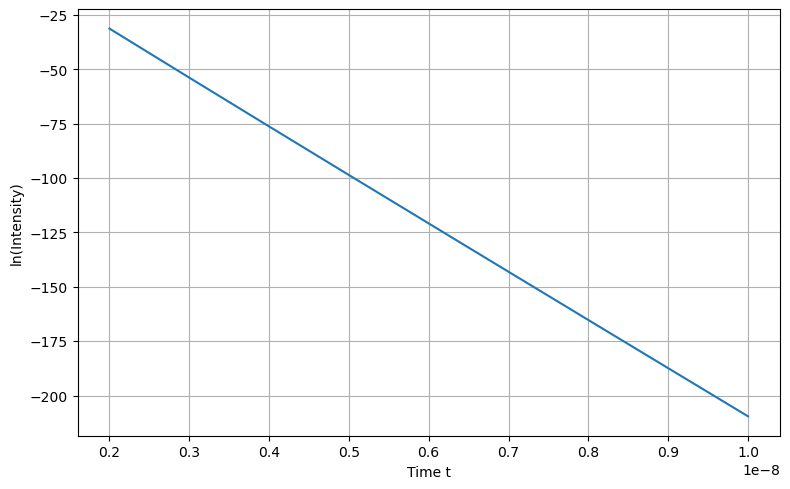

In [696]:
plt.figure(figsize=(8, 5))
plt.plot(t_filtered , intensities[0])
plt.xlabel("Time t")
plt.ylabel("ln(Intensity)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [707]:
# Constants
c = 3e10 / 1.370 
p = [2, 3, 4, 5]
# Initial guess and bounds
initial_guess = [1.0, 1.0, 100]  # [ua, us_prime]
bounds = [(0.001, 4.0), (0.01, 1000.0), (None, 100000)]
result = minimize(objective, initial_guess, args=(t_filtered, intensities, c, g, p), bounds=bounds)
ua_fit, us_prime_fit, intense_fit = result.x
print("Fitted ua= ", ua_fit, ', GT = ', ua)
print("Fitted us_prime = ", us_prime_fit, ', GT=', us_prime)
print(intense_fit)

Fitted ua=  0.9999999630446076 , GT =  1.0
Fitted us_prime =  13.499994574021986 , GT= 13.500000000000002
-9.109417615915973


### Add Gaussian Noise to Model

In [798]:
# noisy model: 
def R_rho_t(t, ua, c, D, z0, rho=1.5):
    # Avoid division by zero for t = 0
    #t = np.where(t == 0, np.finfo(float).eps, t)  # Replace 0 with a small number
    A = (4 * np.pi * D * c) ** (-1.5)
    T = z0 * (t ** (-2.5))
    exp1 = np.exp(-ua * c * t)
    exp2 = np.exp(-(rho**2 + z0**2) / (4 * D * c * t))
    # Return the product
    eta = np.random.normal(0, 1)  # Mean 0, Std 1
    noise = (A * T * exp1 * exp2) * eta * 0.3
    print(A * T * exp1 * exp2,noise)
    return A * T * exp1 * exp2 + noise

In [800]:
t_data = t
t_data = t_data[1: ]
t_safe = np.clip(t, 1e-12, None)
noise_levels = [0.05, 0.05, 0.05, 0.05]

# Step 1: Mask time points after 1e-8
t_mask = t_data > 0.2e-8
t_filtered = t_data[t_mask]  # Use this for modeling

# Step 2: Compute ln(intensity) for each rho, applying the same mask
intensities = []
for rho in [2, 3, 4, 5]:
    #print(rho)
    noise_percentage = noise_levels[rho-2]
    ln_R = np.array([np.log(R_rho_t(x, ua, c, D, z_o, rho=rho)) for x in t_data])
    ln_R = np.where(np.isfinite(ln_R), ln_R, 0)  # Replace nan/inf if needed
    intensities.append(ln_R[t_mask])  # Only keep values after 1e-8

# step2: define the model
def ln_intensity_model(t, ua, us_prime, c, p, intense):
    D = 1 / (3 * (ua + us_prime))
    z_o = 1 / us_prime
    term1 = -ua * c * t
    term2 = -(3/2) * np.log(4 * np.pi * D * c)
    term3 = -(5/2) * np.log(z_o * t)
    term4 = -((p**2 + z_o**2) / (4 * D * c * t))
    return term1 + term2 + term3 + term4 + intense

def objective(params, t, intensities, c, g=0.85, p=[2, 3, 4, 5]):
    ua, us_prime, intense = params
    t = np.clip(t, 1e-12, None)
    error = 0
    try:
        for i in range(len(intensities)):
            pi = p[i]
            pred = ln_intensity_model(t, ua, us_prime, c, pi, intense)
            diff = intensities[i] - pred
            if not np.all(np.isfinite(diff)):
                return 1e20
            error += np.sum(diff**2)
        if not np.isfinite(error):
            return 1e20
    except:
        return 1e20
    return error

1.8499082450374055e-75 -1.1903583389129662e-76
3.7295363425437925e-33 -6.594612355226931e-34
2.6322216628296183e-19 2.4704124327751494e-20
1.6026010030428342e-12 -2.175572751934296e-13
1.5225858251306127e-08 -6.3782648940702046e-09
5.837822388016687e-06 2.6723706312663837e-06
0.0003618745185563764 1.6881972032757612e-05
0.007236601638128635 -0.001853178269930635
0.06841187772407714 0.03852205772606351
0.38413251484125216 0.12413845191383359
1.4804372775422348 0.28927830251060893
4.310670160681698 -1.3651606044547409
10.131591136562937 -4.330398069191114
20.147473933134364 -2.8513463887258337
35.08249095750292 -3.800282688858266
54.88134343044404 1.6743456936061083
78.65065706634864 -0.30259690716356535
104.83063987490054 22.502168638513655
131.50486193157795 -10.466539513897006
156.7371286426558 17.432444261196935
178.85022417863624 -53.765183490021336
196.60349539831856 137.28021838172984
209.26400088838562 -66.61929659546007
216.59012795670802 94.296957745994
218.7567599148005 40.993

C:\Users\Haiya\AppData\Local\Temp\ipykernel_21180\4148583102.py:15: RuntimeWarning: divide by zero encountered in log
  ln_R = np.array([np.log(R_rho_t(x, ua, c, D, z_o, rho=rho)) for x in t_data])


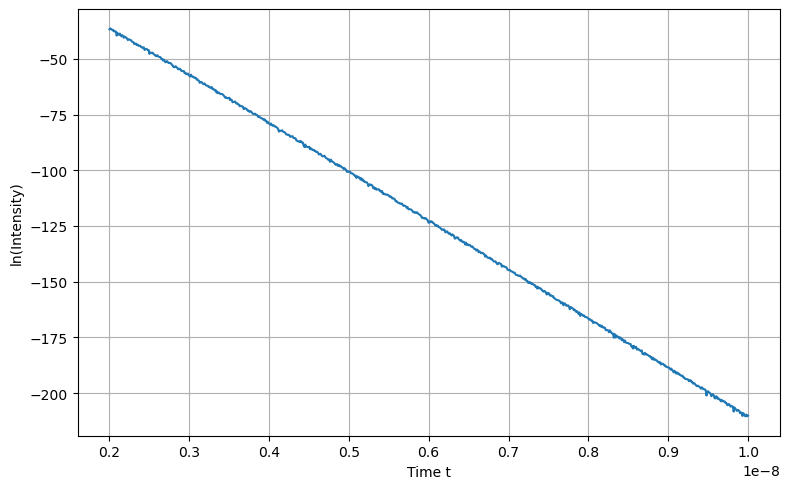

In [802]:
plt.figure(figsize=(8, 5))
plt.plot(t_filtered , intensities[3])
plt.xlabel("Time t")
plt.ylabel("ln(Intensity)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [806]:
# Constants
c = 3e10 / 1.370 
p = [2, 3, 4, 5]
# Initial guess and bounds
initial_guess = [1.0, 1.0, 100]  # [ua, us_prime]
bounds = [(0.001, 4.0), (0.01, 1000.0), (None, 100000)]
result = minimize(objective, initial_guess, args=(t_filtered, intensities, c, g, p), bounds=bounds)
ua_fit, us_prime_fit, intense_fit = result.x
print("Fitted ua= ", ua_fit, ', GT = ', ua)
print("Fitted us_prime = ", us_prime_fit, ', GT=', us_prime)

Fitted ua=  0.9999379753190066 , GT =  1.0
Fitted us_prime =  13.507662167495651 , GT= 13.500000000000002
